In [171]:
#imports
import pandas as pd
import re

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

import altair as alt
from vega_datasets import data
#testing
import doctest

In [172]:
#load datasets
vaccinations = pd.read_csv("COVID-19_Vaccinations.csv", low_memory=False)
covid_cases = pd.read_csv("covid_confirmed_usafacts.csv", low_memory=False)
death_cases = pd.read_csv("covid_deaths_usafacts.csv", low_memory=False)
gdp_by_county = pd.read_csv("GDP by County.csv", low_memory=False)


In [173]:
#testing datasets
vax_small = vaccinations.head(10)
cases_small = covid_cases.head(10)
deaths_small = death_cases.head(10)
gdp_small = gdp_by_county.head(10)

In [174]:
gdp_by_county = pd.read_csv("GDP by County.csv", low_memory=False)
def clean_gdp_by_county(df):
    # reformating
    # Drop rows where all cells are NaN
    '''
    TODO: Write docstring

    Testing:
        (1) Sanity check column names are correct
            (a) no 'County' at the end
            (b) no United States (Country name) or Alabama (State name)
        (2) Check length of dataset (correct # of columns) TODO
    >>> clean_gdp_by_county(gdp_small)
                GDP_20     GDP_21     GDP_22     GDP_23
    County                                             
    Autauga  1,746,979  1,736,001  1,895,751  1,945,909
    Baldwin  8,109,210  8,706,236  9,145,388  9,435,720
    Barbour    732,151    753,330    744,850    715,994
    Bibb       460,844    460,027    457,625    466,543
    Blount     906,582  1,033,615  1,031,061    987,208
    Bullock    269,007    260,950    252,515    267,926
    Butler     601,322    639,245    656,864    660,757
    '''
    df = df.iloc[1:] #united states is first row
    df = df.dropna(how='all') #drops all all-blank rows
    states = [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
        "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
        "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
        "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
        "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
        "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]

    # Drop rows where the index (county) is actually a state name
    df.set_index("County", inplace=True)
    df = df[~df.index.isin(states)]
   
    return df
doctest.run_docstring_examples(clean_gdp_by_county, globals())
gdp_by_county = clean_gdp_by_county(gdp_by_county) #update gdp w cleaned version


In [175]:
vaccinations = pd.read_csv("COVID-19_Vaccinations.csv", low_memory=False)
def clean_vax_df(df):
    '''
    TODO: Write Docstring
    TODO: Aggregate data per date instead of lazy drop dup way

    Testing:
        (1) Sanity check column names are correct
        (2) Check length of dataset (correct # of columns) TODO


    '''
    #clean vaccination dataset
    # Convert the 'Date' column to datetime format
    #df_vax["Date"] = pd.to_datetime(df_vax["Date"], format="%m/%d/%Y")

    # Extract Year, Month, and Day
    # df_vax["Year"] = df_vax["Date"].dt.year
    # df_vax["Month"] = df_vax["Date"].dt.month
    # df_vax["Day"] = df_vax["Date"].dt.day

    df["Recip_County"] = df["Recip_County"].str.replace(" County", "").str.strip()

    # Rename columns to match indexing convention
    df = df.rename(columns={"Recip_County": "County", "Recip_State": "State"})

    # Select only relevant columns
    df = df[["FIPS", "State", "County", "Series_Complete_Yes", 
                    "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct"]]
    
    df = df[df['County'] != 'Unknown']
    df['FIPS'] = df['FIPS'].astype('int64')
    # Set the multi-index
    df.drop_duplicates(subset=['FIPS'], inplace=True) #most recent vax data
    df.set_index(["FIPS"], inplace=True)
    return df

doctest.run_docstring_examples(clean_vax_df, globals())
vaccinations = clean_vax_df(vaccinations)

In [176]:
vaccinations

,State,County,Series_Complete_Yes,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct
FIPS,,,,,
55129,WI,Washburn,10325.0,65.7,65.9
19173,IA,Taylor,2951.0,48.2,61.1
36059,NY,Nassau,1179481.0,86.9,46.5
48281,TX,Lampasas,10007.0,46.7,42.1
26145,MI,Saginaw,103137.0,54.1,56.9
...,...,...,...,...,...
29153,MO,Ozark,3057.0,33.3,47.2
46065,SD,Hughes,13461.0,76.8,51.1
26027,MI,Cass,23657.0,45.7,46.0


In [177]:
covid_cases = pd.read_csv("covid_confirmed_usafacts.csv", low_memory=False)
def clean_cases_df(df):
    '''
    Testing:
        (1) Sanity check column names are correct
        (2) Check length of dataset (correct # of columns) TODO
    '''
    # Standardize county names (remove " County")
    df["County Name"] = df["County Name"].str.replace(" County", "").str.strip()

    # Rename columns for consistency
    df.rename(columns={"County Name": "County", "State": "State", "countyFIPS":"FIPS"}, inplace=True)

    # Drop unnecessary columns
    df.drop(columns=["StateFIPS"], inplace=True)

    # Convert wide format (dates as columns) to long format
    df_melted = df.melt(id_vars=["State", "County", "FIPS"], var_name="Date", value_name="Cases",)

    df_summed = (
        df_melted
        .groupby(["FIPS", "County", "State"], as_index=False)["Cases"] #total # of COVID--related deaths from 2020-2023
        .sum()
    )

    # Drop the original Date column
    #df_summed.drop(columns=["d"], inplace=True)
    df_summed = df_summed[df_summed["County"] != "Statewide Unallocated"]

    # Set multi-index
    df_summed.set_index(["FIPS"], inplace=True)
    return df_summed
doctest.run_docstring_examples(clean_cases_df, globals())
covid_cases = clean_cases_df(covid_cases)

In [178]:
def clean_deaths_df(df):
    '''
    TODO: Write Docstring -> might need to select differen subset where deaths aren't

    Testing:
        (1) Sanity check column names are correct
        (2) Check length of dataset (correct # of columns) TODO
    
    '''
    # Drop unnecessary columns
    df = df.drop(columns=["StateFIPS"], errors="ignore")

    # Rename columns for consistency
    df = df.rename(columns={"County Name": "County", "State": "State", "countyFIPS": "FIPS",})

    # Standardize county names (remove "County" and extra spaces)
    df["County"] = df["County"].str.replace(" County", "").str.strip()

    # Remove rows where County is "Statewide Unallocated"
    df = df[df["County"] != "Statewide Unallocated"]

    df_melted = df.melt(id_vars=["State", "County", "FIPS"], var_name="Date", value_name="Deaths")

    df_summed = (
        df_melted
        .groupby(["FIPS", "County", "State"], as_index=False)["Deaths"] #total # of COVID--related deaths from 2020-2023
        .sum()
    )

    # Set multi-index
    df_summed.set_index(["FIPS"], inplace=True)
    return df_summed
doctest.run_docstring_examples(clean_deaths_df, globals())
#display(clean_deaths_df(death_cases))
death_cases = clean_deaths_df(death_cases)

In [179]:
def merge_datasets():
    '''
    TODO: Write Docstring
    '''

    #CHANGED FROM OUTER -> INNER
    df_combined = covid_cases.merge(death_cases, on=["FIPS", "County", "State"], how="inner")
    df_combined = df_combined.merge(vaccinations, on=["FIPS", "County", "State"], how="inner")
    
    #setup so we can merge on county
    df_combined.reset_index()
    #df_combined['FIPS'] = df_combined['FIPS'].astype('int64')

    gdp_reset = gdp_by_county.reset_index()
    df_combined.reset_index(inplace=True)

    df_combined = df_combined.merge(gdp_reset, on="County", how="inner")
    df_combined.drop_duplicates(subset=['FIPS'], inplace=True) #prob need to find GDP dataset that has FIPS
    df_combined.set_index('FIPS', inplace=True)
    
    return df_combined
df_combined = merge_datasets()
df_combined

,County,State,Cases,Deaths,Series_Complete_Yes,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,GDP_20,GDP_21,GDP_22,GDP_23
FIPS,,,,,,,,,,,
1001,Autauga,AL,13075941,169233,25756.0,46.1,38.0,"1,746,979","1,736,001","1,895,751","1,945,909"
1003,Baldwin,AL,45828008,535518,119284.0,53.4,39.9,"8,109,210","8,706,236","9,145,388","9,435,720"
1005,Barbour,AL,4794164,79709,11703.0,47.4,37.4,"732,151","753,330","744,850","715,994"
1007,Bibb,AL,5308378,86888,8178.0,36.5,42.3,"460,844","460,027","457,625","466,543"
1009,Blount,AL,12457036,194138,19005.0,32.9,37.0,"906,582","1,033,615","1,031,061","987,208"
...,...,...,...,...,...,...,...,...,...,...,...
56037,Sweetwater,WY,8635566,92268,22392.0,52.9,43.2,"3,404,245","3,339,081","3,242,411","3,414,965"
56039,Teton,WY,7842202,12918,22802.0,95.0,51.6,"373,968","433,632","472,076","491,722"
56041,Uinta,WY,4430996,29130,10932.0,54.0,43.0,"781,034","808,678","836,424","870,000"


In [181]:
def reformat_GDP(df_cases):
    df = df_cases
    #turn gdp2x -> gdp column for a give year
   

    # # #TESTING W THIS -- too many rows
    #df.dropna(how='all', inplace=True)
    gdp_columns = ['GDP_20', 'GDP_21', 'GDP_22', 'GDP_23']

    # # Remove commas if present and convert each column to an integer
    for col in gdp_columns:
        df[col] =  df[col].str.replace(',', '').astype(float)  

    #df['GDP'] = df[['GDP_20', 'GDP_21', 'GDP_22', 'GDP_23']].sum(axis=1)
    df['GDP_GROWTH'] = (df['GDP_23'] - df['GDP_20']) / df['GDP_20']
    
    
    display(df)

    return df

df_combined = reformat_GDP(df_combined) #diff ver. with less rows

,County,State,Cases,Deaths,Series_Complete_Yes,Series_Complete_Pop_Pct,Booster_Doses_Vax_Pct,GDP_20,GDP_21,GDP_22,GDP_23,GDP_GROWTH
FIPS,,,,,,,,,,,,
1001,Autauga,AL,13075941,169233,25756.0,46.1,38.0,1746979.0,1736001.0,1895751.0,1945909.0,0.113871
1003,Baldwin,AL,45828008,535518,119284.0,53.4,39.9,8109210.0,8706236.0,9145388.0,9435720.0,0.163581
1005,Barbour,AL,4794164,79709,11703.0,47.4,37.4,732151.0,753330.0,744850.0,715994.0,-0.022068
1007,Bibb,AL,5308378,86888,8178.0,36.5,42.3,460844.0,460027.0,457625.0,466543.0,0.012366
1009,Blount,AL,12457036,194138,19005.0,32.9,37.0,906582.0,1033615.0,1031061.0,987208.0,0.088934
...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Sweetwater,WY,8635566,92268,22392.0,52.9,43.2,3404245.0,3339081.0,3242411.0,3414965.0,0.003149
56039,Teton,WY,7842202,12918,22802.0,95.0,51.6,373968.0,433632.0,472076.0,491722.0,0.314877
56041,Uinta,WY,4430996,29130,10932.0,54.0,43.0,781034.0,808678.0,836424.0,870000.0,0.113908


### regional patterns

In [193]:
def series_by_county():
    df = df_combined[['County','State','Series_Complete_Pop_Pct']].reset_index()

    counties = alt.topo_feature(data.us_10m.url, 'counties')
    df.dropna(subset=['County','State','Series_Complete_Pop_Pct'], inplace=True)
    

    chart = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color=alt.Color(
                'Series_Complete_Pop_Pct:Q',
                scale=alt.Scale(scheme="redblue", domain=[0, 100]),
                legend=alt.Legend(title="Series Complete % per County")
            ),

            tooltip=['County:N', 'State:N', 'Series_Complete_Pop_Pct:Q']
        )
        .transform_lookup(
            lookup='id',
            from_=alt.LookupData(df, 'FIPS', ['Series_Complete_Pop_Pct', 'State', 'County'])
        )
        .project(type='albersUsa')
        .properties(width=700, height=400, title="Vaccination Series Completed % Per County")
    )
    display(chart)
series_by_county()

alt.Chart(...)

In [195]:
def map_gdp():
    df = df_combined.reset_index()[["State", "County", "FIPS", "GDP_GROWTH"]]

    #df['Year'] = df['Year'].astype(str)
    df.drop_duplicates(inplace=True)

    #display(df.dtypes)
    alt.data_transformers.disable_max_rows()

    # TopoJSON of US counties
    counties = alt.topo_feature(data.us_10m.url, 'counties')


    map_chart = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color=alt.Color('GDP_GROWTH:Q').scale(scheme="redblue", domain=[-.3,.3]),
            tooltip=['County:N', 'State:N', 'GDP_GROWTH:Q']
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['GDP_GROWTH', 'Year', 'State', 'County']) #'County', 'State', 'GDP', 'Year'
        )
        # .transform_filter(year_select)
        .project(type='albersUsa')
        .properties(width=700, height=400, title="GDP Growth (2020-2023)")
        #.add_params(year_select)
    )
    display(map_chart) 

map_gdp()

alt.Chart(...)

Notes:
- Change deaths column from # to %
- Make sure tests are robust



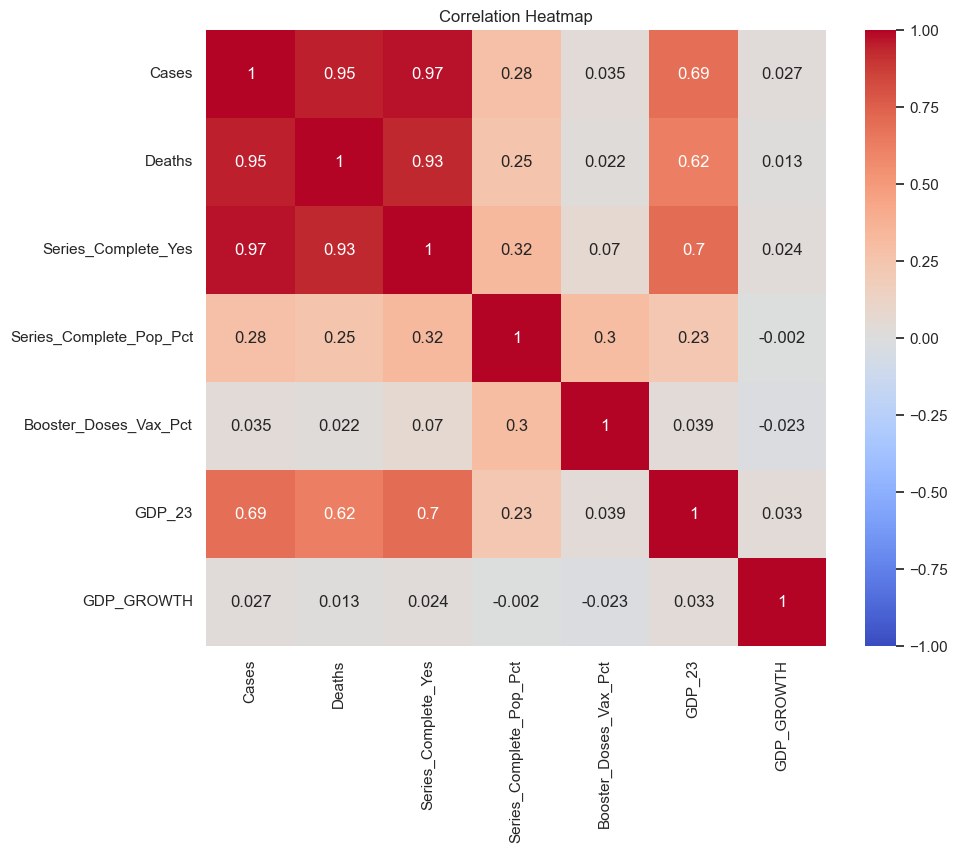

In [201]:
def corr_heatmap(df):
    corr_matrix = df[['Cases', 'Deaths', 'Series_Complete_Yes', 'Series_Complete_Pop_Pct', 'Booster_Doses_Vax_Pct', 'GDP_23', 'GDP_GROWTH']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, 
        annot=True,          # Shows the correlation values on the heatmap
        cmap="coolwarm",     # Color palette
        vmin=-1, vmax=1      # Ensures the color scale goes from -1 to 1
    )
    plt.title("Correlation Heatmap")
    plt.show()
corr_heatmap(df_combined)